In [1]:
import requests
import lxml.html as lh
import pandas as pd

# Etape 1 : Web Scraping des données d’avis de spectacteurs

In [104]:
# URL
url = 'http://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
# URI-SUFFIX
uri_pages = '?page='
# Number of pages to read
nbPages = 400
# XPath content to collect
tags = ['//span[@class="stareval-note"]', \
        '//div[@class="content-txt review-card-content"]' ]
cols = ['Note', \
        'Description' ]

In [105]:
page = requests.get(url)
doc = lh.fromstring(page.content)

In [106]:
def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)

    # Get the Web data via XPath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))

    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)

    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
    
    return liste

In [107]:
def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = getPage(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale

liste_totale = getPages(nbPages, url)


In [108]:
del liste_totale['key']

In [109]:
liste_totale.head()

,Note,Description
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...
1,"5,0",C’est fou ce qu’on aime détester Christopher N...
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...
3,"5,0","Un film aussi novateur que complexe, dont la m..."
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...


In [5]:
liste_totale.to_csv('inception_avis_allocine.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Etape 2 et 3 : Préparation des données et des libellés

In [33]:
liste_totale = pd.read_csv('inception_avis_allocine.csv')

In [34]:
import csv
import re

REMPLACE_SANS_ESPACE = re.compile("[;:!?,\"()\[\]]")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.’\']")

def preprocess(txt):
    txt = [line.replace('\n', ' ')  for line in txt] # Retire les \n (retours chariots)
    txt = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in txt]
    txt = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in txt]
    return txt

liste_totale['Description'] = pd.DataFrame(preprocess(liste_totale['Description']))

In [35]:
liste_totale.to_csv('inception_avis.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [36]:
liste_totale.head()

,Note,Description
0,"5,0",après le chef d oeuvre super héroïque the dark...
1,"5,0",c est fou ce qu on aime détester christopher n...
2,"5,0",chef d œuvre le film est absolument parfait ...
3,"5,0",un film aussi novateur que complexe dont la mi...
4,"3,5",le meilleur blockbuster de 2010 a pour thème l...


In [37]:
df = pd.read_csv('inception_avis.csv')

In [38]:
df.head()

,Note,Description
0,"5,0",après le chef d oeuvre super héroïque the dark...
1,"5,0",c est fou ce qu on aime détester christopher n...
2,"5,0",chef d œuvre le film est absolument parfait ...
3,"5,0",un film aussi novateur que complexe dont la mi...
4,"3,5",le meilleur blockbuster de 2010 a pour thème l...


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         6000 non-null   object
 1   Description  5999 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [40]:
df[df['Description'].isna()]

,Note,Description
3024,"0,5",NaN


In [41]:
df = df.dropna(axis = "rows")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         5999 non-null   object
 1   Description  5999 non-null   object
dtypes: object(2)
memory usage: 140.6+ KB


In [43]:
df['Note'].unique()

array(['5,0', '3,5', '4,0', '4,5', '2,0', '3,0', '1,0', '0,5', '1,5',
       '2,5'], dtype=object)

In [44]:
df['Note'][0]

'5,0'

In [45]:
nb = df['Note'][0]

In [46]:
x = nb.replace(",",".")

In [47]:
print(x)

5.0


In [48]:
for i in df['Note'].index:
    df['Note'][i] = df['Note'][i].replace(',','.')

In [49]:
df['Note'].unique()

array(['5.0', '3.5', '4.0', '4.5', '2.0', '3.0', '1.0', '0.5', '1.5',
       '2.5'], dtype=object)

In [50]:
df['Note'] = df['Note'].astype(float, errors = 'raise')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Note         5999 non-null   float64
 1   Description  5999 non-null   object 
dtypes: float64(1), object(1)
memory usage: 269.6+ KB


In [52]:
f = lambda x: 1 if x>2.5 else 0
df['Note'] = df['Note'].map(f)

In [53]:
df['Note'].unique()

array([1, 0], dtype=int64)

In [54]:
df['Note'] = df['Note'].astype(int, errors = 'raise')

In [55]:
df['Note'].unique()

array([1, 0])

In [56]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('french'))
from nltk.tokenize import word_tokenize

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [57]:
liste_mot = []
for i in df['Description'].index:
    example_sent = df['Description'][i]
    
    stop_words = set(stopwords.words('french'))
    s=set(['a', 'à', 'cet', 'cette', 'cettes', 'après', 'tôt',"c\'est", "qu\'on"])
    stop_words=stop_words.union(s)
    
    word_tokens = word_tokenize(example_sent)
    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    
    liste_mot.append(filtered_sentence)

In [58]:
df['liste_mot'] = liste_mot

In [59]:
df.head()

,Note,Description,liste_mot
0,1,après le chef d oeuvre super héroïque the dark...,"[chef, oeuvre, super, héroïque, the, dark, kni..."
1,1,c est fou ce qu on aime détester christopher n...,"[fou, aime, détester, christopher, nolan…plus,..."
2,1,chef d œuvre le film est absolument parfait ...,"[chef, œuvre, film, absolument, parfait, acteu..."
3,1,un film aussi novateur que complexe dont la mi...,"[film, aussi, novateur, complexe, dont, mise, ..."
4,1,le meilleur blockbuster de 2010 a pour thème l...,"[meilleur, blockbuster, 2010, thème, délicate,..."


# Etape 4 : Finalisation de nos jeux de données

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(df['liste_mot'], df['Note'], test_size=.2, random_state=0)

In [145]:
X_train.shape, X_test.shape

((4799,), (1200,))

In [134]:
X_train_phrase = []

for i in X_train:
    X_train_phrase.append(' '.join(i))
    

In [135]:
X_train_phrase

['conseil allez voir film tard soir journée boulot noeud cerveau garanti hormis fait difficile comprendre début excellent film sous tous rapports conseille vivement',
 'dès début christopher nolan su immiscer cinéma contemporain grand coup scénarios originaux habilement mis scène entouré acteurs qualité chose pleinement confirmée deux reboots batman particulier chef oeuvre the dark knight septième film avère aller delà limites réalisateur britannique delà imaginé car inception nolan livre oeuvre plus incroyable plus touchante aussi sorte génie matérialisé long métrage masterpiece inédit tornade fraicheur monde cinéma résumer inception impossible expliquer pleinement tout autant film plus complexes donné voir scénario fois dur cerner entièrement logique fourmillant détails cohérence dialogues réfléchis situations alambiquées tout bien sûr agrémenté réalisation exemplaire inspirée philip k dick stanley kubrick encore satoshi kon autour plans séquences sobres effets visuels hallucinants p

In [151]:
vectorizer = CountVectorizer(min_df=.01)

vectorizer.fit(X_train_phrase)

vector = vectorizer.transform(X_train_phrase)

In [152]:
vector

<4799x655 sparse matrix of type '<class 'numpy.int64'>'
	with 121485 stored elements in Compressed Sparse Row format>

## Visualisation nuage de mot

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [142]:
positif = []
negatif = []

for i in df['liste_mot'].index:
    if df['Note'][i] == 1:
        positif.append(df['liste_mot'][i])
    else:
        negatif.append(df['liste_mot'][i])

### WordCloud avec les avis positifs

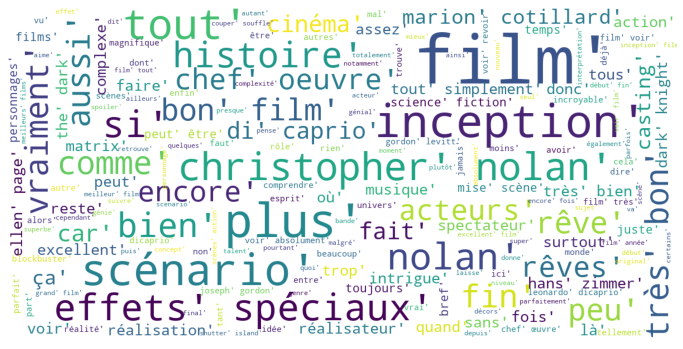

In [143]:
show_wordcloud(positif)

### WordCloud avec les avis positifs

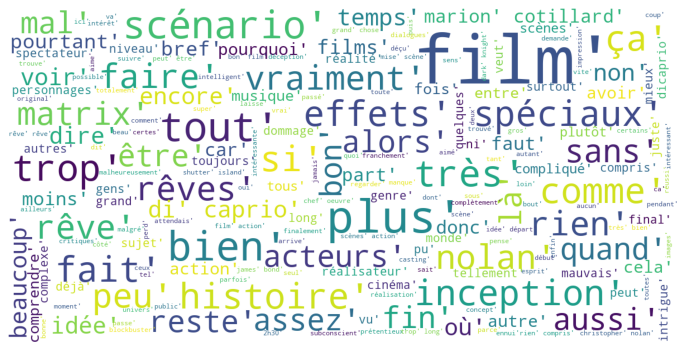

In [144]:
show_wordcloud(negatif)